#Note: Before running the colab notebook, please change the runtime to GPU

##Step 1: Install required libraries

####Install pytorch, opencv, matplotlib and pycocotools

In [1]:
# Install pytorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install other libraries
!pip install opencv-python matplotlib pycocotools

Looking in indexes: https://download.pytorch.org/whl/cu118


####Install Detectron2 model from github

In [2]:
# Install compatible Detectron2 version for current PyTorch
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-802p6v79
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-802p6v79
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.1 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352521 sha256=144606f23e7b5a85d98af629c79394450521bf61001fa874d4b3186cd9f132a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfsucuap/wheels/d3/6e/bd/1969578f1456a6be

####Incase there is a broken installation, remove installed detectron2 and install again

In [78]:
# !pip uninstall -y detectron2.

Found existing installation: detectron2 0.6
Uninstalling detectron2-0.6:
  Successfully uninstalled detectron2-0.6


Check if the dectectron was installed successfully and works

In [3]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer

print("Detectron2 installed successfully!")

Detectron2 installed successfully!


##Step 2: Download the COCO dataset

In [4]:
from pycocotools.coco import COCO
import requests
import cv2
import matplotlib.pyplot as plt
import os

# Download small COCO dataset subset (annotations + images)
!mkdir -p coco_dataset
!wget -q -P coco_dataset http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# Download val2017 images (~1GB)
!wget http://images.cocodataset.org/zips/val2017.zip -P coco_dataset/

# Unzip inside coco_dataset/
!unzip coco_dataset/val2017.zip -d coco_dataset/
!unzip -q coco_dataset/annotations_trainval2017.zip -d coco_dataset

Streaming output truncated to the last 5000 lines.
 extracting: coco_dataset/val2017/000000212226.jpg  
 extracting: coco_dataset/val2017/000000231527.jpg  
 extracting: coco_dataset/val2017/000000578922.jpg  
 extracting: coco_dataset/val2017/000000062808.jpg  
 extracting: coco_dataset/val2017/000000119038.jpg  
 extracting: coco_dataset/val2017/000000114871.jpg  
 extracting: coco_dataset/val2017/000000463918.jpg  
 extracting: coco_dataset/val2017/000000365745.jpg  
 extracting: coco_dataset/val2017/000000320425.jpg  
 extracting: coco_dataset/val2017/000000481404.jpg  
 extracting: coco_dataset/val2017/000000314294.jpg  
 extracting: coco_dataset/val2017/000000335328.jpg  
 extracting: coco_dataset/val2017/000000513688.jpg  
 extracting: coco_dataset/val2017/000000158548.jpg  
 extracting: coco_dataset/val2017/000000132116.jpg  
 extracting: coco_dataset/val2017/000000415238.jpg  
 extracting: coco_dataset/val2017/000000321333.jpg  
 extracting: coco_dataset/val2017/000000081738.j

##Step 3: Load the detectron2 model to detect sky and remove it from images

In [5]:
import cv2
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [9]:
# Load panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

####Function to remove sky from images and get it's mask

In [10]:
def remove_sky_and_get_mask(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run panoptic segmentation
    outputs = predictor(img_rgb)["panoptic_seg"]
    panoptic_seg, segments_info = outputs


    for seg in segments_info:
      print(seg)

    #sky_mask = None
    sky_mask = np.zeros(panoptic_seg.shape, dtype=bool)
    for seg in segments_info:
        if seg["category_id"] == 40:  # COCO category 40 = sky
            #sky_mask = (panoptic_seg == seg["id"]).cpu().numpy()
            sky_mask = sky_mask | (panoptic_seg.cpu().numpy() == seg['id'])
            break

    #Find sky segment
    plt.imshow(sky_mask)
    plt.title("Sky Mask")
    plt.show()

    if sky_mask is not None:
        # Crop image from first non-sky row
        # rows = np.any(~sky_mask, axis=1)
        # first_row = np.argmax(rows)
        # img_no_sky = img_rgb[first_row:, :, :]
        rows_with_non_sky = np.any(~sky_mask, axis=1)
        first_row = np.argmax(rows_with_non_sky)  # first row without sky
        img_no_sky = img_rgb[first_row:, :, :]
        return img_no_sky

    else:
        # No sky detected → return original
        return img_rgb

Testing 5 sample images

In [11]:
import os
import numpy as np

coco_annotation_file = "coco_dataset/annotations/instances_val2017.json"
coco = COCO(coco_annotation_file)

# Pick 5 sample images
# Get all annotations that include sky
sky_cat_id = 21  # COCO category for sky
img_ids_with_sky = coco.getImgIds(catIds=[sky_cat_id])

# # Pick 5 images that actually have sky
img_ids = img_ids_with_sky[:5]
# img_ids = coco.getImgIds()[:5]

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"coco_dataset/val2017/{img_info['file_name']}"  # Ensure you downloaded images here


    print(img_path, os.path.exists(img_path))

    img_no_sky = remove_sky_and_get_mask(img_path)
    plt.imshow(img_no_sky)
    plt.axis('off')
    plt.show()

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
coco_dataset/val2017/000000435206.jpg True


NameError: name 'predictor' is not defined

####Registers a COCO dataset in Detectron2, making the images and annotations accessible by name along with their metadata.

In [12]:
from detectron2.data.datasets import load_coco_json
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "coco_val"
json_file = "coco_dataset/annotations/instances_val2017.json"
image_root = "coco_dataset/val2017"

if "coco_val" in DatasetCatalog.list():
    DatasetCatalog.remove("coco_val")
    MetadataCatalog.remove("coco_val")

DatasetCatalog.register("coco_val", lambda: load_coco_json(json_file, image_root, "coco_val"))
dataset_dicts = DatasetCatalog.get("coco_val")
metadata = MetadataCatalog.get("coco_val")

####Function to remove the sky mask from images

In [13]:
def remove_sky_mask(img, predictor):
    """
    Returns the image with the sky masked out (black) and the sky mask itself.
    """
    outputs = predictor(img)["panoptic_seg"]
    panoptic_seg = outputs[0].cpu().numpy()
    segments_info = outputs[1]

    sky_mask = np.zeros_like(panoptic_seg, dtype=np.uint8)
    for seg in segments_info:
        if seg["category_id"] == sky_class_id:
            sky_mask[panoptic_seg == seg["id"]] = 255

    img_no_sky = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(sky_mask))
    return img_no_sky, sky_mask

####Function to crop the sky part from images

In [11]:
def crop_sky_from_image(img, predictor):
    """
    Crops out all rows that contain sky.
    Returns the cropped image and the number of rows cropped from the top.
    """
    outputs = predictor(img)["panoptic_seg"]
    panoptic_seg = outputs[0].cpu().numpy()
    segments_info = outputs[1]

    # Create sky mask
    sky_mask = np.zeros_like(panoptic_seg, dtype=np.uint8)
    for seg in segments_info:
        if seg["category_id"] == sky_class_id:
            sky_mask[panoptic_seg == seg["id"]] = 255

    # Find the bottom-most row that contains sky
    sky_rows = np.any(sky_mask == 255, axis=1)
    if not np.any(sky_rows):
        # No sky detected
        return img, 0
    bottom_sky_row = np.max(np.where(sky_rows)[0])  # last row containing sky

    # Crop everything above this row
    img_cropped = img[bottom_sky_row + 1:, :, :]
    return img_cropped, bottom_sky_row + 1

####Visulizing the results

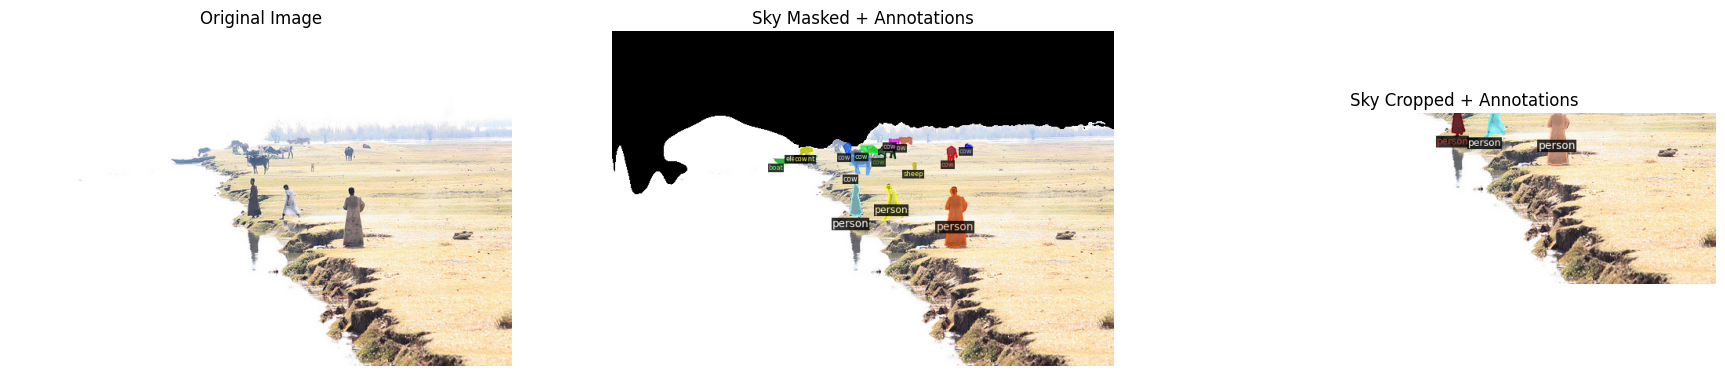

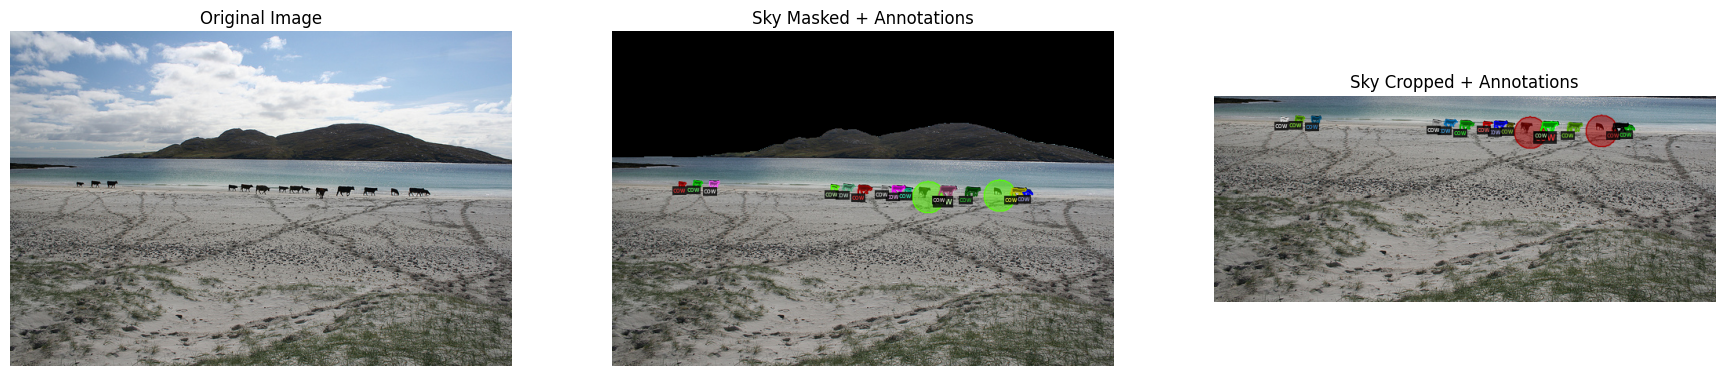

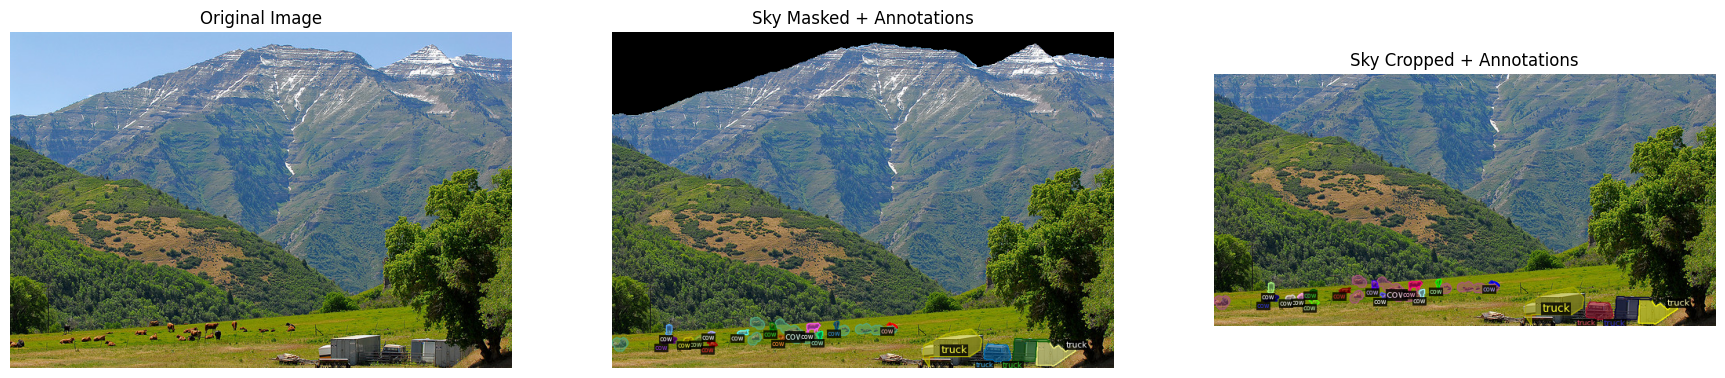

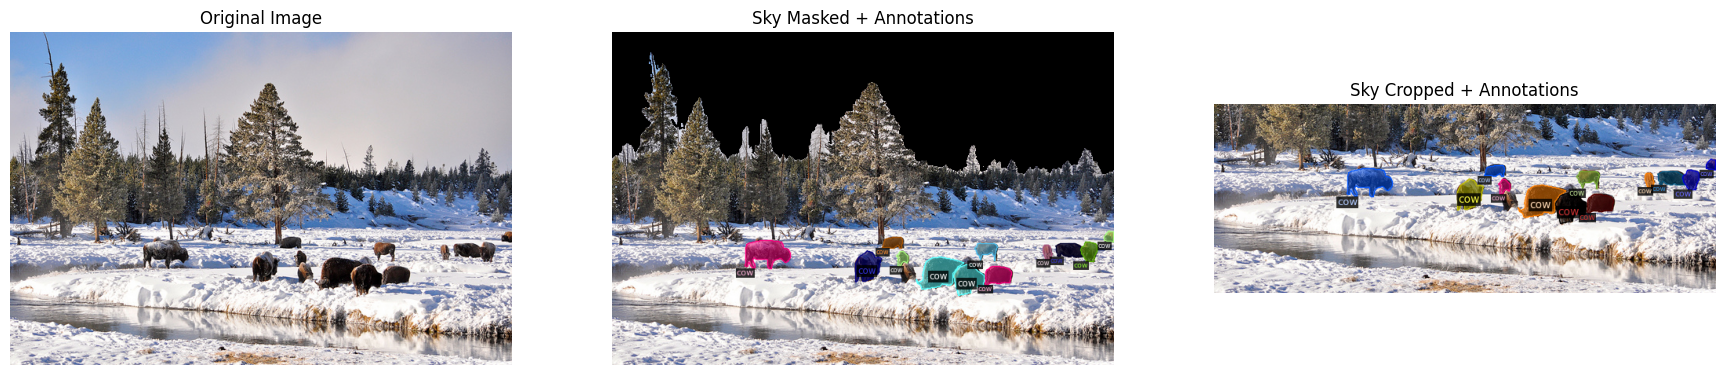

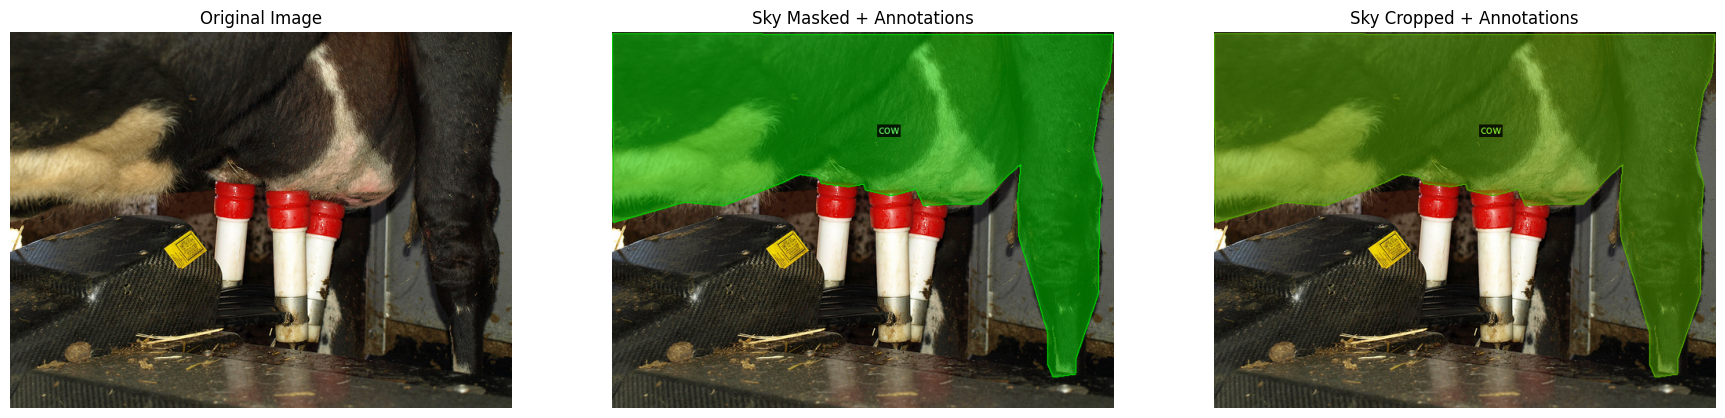

In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode

sky_class_id = 40  # COCO category ID for sky

# Loop over images
for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"coco_dataset/val2017/{img_info['file_name']}"

    # Load original image
    img_orig = cv2.imread(img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Sky-masked image
    img_no_sky, sky_mask = remove_sky_mask(img_orig, predictor)

    # Sky-cropped image
    img_cropped, top_row = crop_sky_from_image(img_orig, predictor)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    dataset_id_to_contiguous_id = metadata.thing_dataset_id_to_contiguous_id
    masks_no_sky, masks_cropped, labels = [], [], []

    for ann in anns:
        if ann["category_id"] in dataset_id_to_contiguous_id:
            mask = coco.annToMask(ann)

            # For sky-masked image: mask stays full size
            masks_no_sky.append(mask.astype(np.uint8))

            # For sky-cropped image: crop mask same way as image
            mask_cropped = mask[top_row:, :]
            masks_cropped.append(mask_cropped)

            contiguous_id = dataset_id_to_contiguous_id[ann["category_id"]]
            labels.append(metadata.thing_classes[contiguous_id])

    # Visualizer for sky-masked image
    v_masked = Visualizer(
        img_no_sky,
        metadata=metadata,
        scale=1.0,
        instance_mode=ColorMode.IMAGE
    )
    v_masked = v_masked.overlay_instances(masks=masks_no_sky, labels=labels)

    # Visualizer for sky-cropped image
    v_cropped = Visualizer(
        img_cropped,
        metadata=metadata,
        scale=1.0,
        instance_mode=ColorMode.IMAGE
    )
    v_cropped = v_cropped.overlay_instances(masks=masks_cropped, labels=labels)

    # Side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    axes[0].imshow(img_orig)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(v_masked.get_image())
    axes[1].set_title("Sky Masked + Annotations")
    axes[1].axis("off")

    axes[2].imshow(v_cropped.get_image())
    axes[2].set_title("Sky Cropped + Annotations")
    axes[2].axis("off")

    plt.show()


##Step 4: Save the new images and annotations to create a new dataset

In [ ]:
import json

new_dataset = {
    "images": [],
    "annotations": [],
    "categories": metadata.thing_classes  # or copy from original COCO JSON
}

new_ann_id = 1  # unique ID for new annotations

In [ ]:
for img_id in coco.getImgIds():
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"coco_dataset/val2017/{img_info['file_name']}"
    img_orig = cv2.imread(img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Crop sky
    img_cropped, top_row = processor.crop_sky(img_orig)

    # Save new image
    new_img_name = f"{img_info['file_name'].split('.')[0]}_cropped.jpg"
    save_path = f"coco_sky_removed/cropped/{new_img_name}"
    cv2.imwrite(save_path, cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR))

    # Update image info
    new_dataset["images"].append({
        "id": img_id,
        "file_name": new_img_name,
        "height": img_cropped.shape[0],
        "width": img_cropped.shape[1]
    })

    # Update annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        mask = coco.annToMask(ann)
        mask_cropped = mask[top_row:, :]  # adjust mask to cropped image
        if mask_cropped.sum() == 0:
            continue  # skip annotations fully in the cropped-out sky

        # Convert mask to RLE (COCO format)
        from pycocotools import mask as mask_utils
        rle = mask_utils.encode(np.asfortranarray(mask_cropped.astype(np.uint8)))
        rle["counts"] = rle["counts"].decode("utf-8")  # JSON friendly

        # Update annotation
        new_dataset["annotations"].append({
            "id": new_ann_id,
            "image_id": img_id,
            "category_id": ann["category_id"],
            "segmentation": rle,
            "area": int(mask_cropped.sum()),
            "bbox": mask_utils.toBbox(rle).tolist(),
            "iscrowd": ann.get("iscrowd", 0)
        })
        new_ann_id += 1

In [ ]:
with open("coco_sky_removed/cropped_annotations.json", "w") as f:
    json.dump(new_dataset, f)
